## Figure 3
### Networks of Iamb-4 in each 5-year time slice

Load packages and data

In [1]:
library(tidyverse)

library(igraph)
library(ggraph)

library(wesanderson)
theme_set(theme_minimal())

── Attaching packages ─────────────────────────────────────── tidyverse 1.3.2 ──
✔ ggplot2 3.4.1     ✔ purrr   1.0.1
✔ tibble  3.1.8     ✔ dplyr   1.1.0
✔ tidyr   1.3.0     ✔ stringr 1.5.0
✔ readr   2.1.4     ✔ forcats 1.0.0
── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()

Dołączanie pakietu: ‘igraph’


Następujące obiekty zostały zakryte z ‘package:dplyr’:

    as_data_frame, groups, union


Następujące obiekty zostały zakryte z ‘package:purrr’:

    compose, simplify


Następujący obiekt został zakryty z ‘package:tidyr’:

    crossing


Następujący obiekt został zakryty z ‘package:tibble’:

    as_data_frame


Następujące obiekty zostały zakryte z ‘package:stats’:

    decompose, spectrum


Następujący obiekt został zakryty z ‘package:base’:

    union




In [10]:
# load model output
load("../data/lda75_output.Rda")

# load code for edges calculation
source("03_fn_calculate_edges.R")

# function to extract topic lables:
get_topic_labels = function(x, n_labels = 10) {
  
  #takes beta-matrix as an input
  top_terms = x %>%
    group_by(topic) %>%
    top_n(20, beta) %>%
    ungroup() %>%
    arrange(topic, -beta)
  
  topic_labels = top_terms %>%
    group_by(topic) %>%
    top_n(n_labels, beta) %>%
    summarise(label=paste(term, collapse=" ")) %>%
    mutate(label = paste(topic, label, sep="_"))
  
  return(topic_labels)
}


#### Data preparation

In [11]:
# prepare gamma data
gamma <- gamma %>% 
    # select ONLY RNC connections & topics
    filter(corpus == "N") %>% 
    # add index for create_edges function
    mutate(index = paste0(corpus, "_", id)) %>% 
    # fix typo
    rename(author = first_line)

topic_labels <- get_topic_labels(beta, n_labels = 5)

# calculate edges
edges_raw <- compute_edges(gamma,
                           gamma_thresh = 0.05,
                           time_slice = 5)

# select top meters
meter_counts <- gamma %>% 
  mutate(year_span = floor(as.numeric(year)/5)*5) %>% 
  rename("meter" = "formula") %>% 
  filter(!str_detect(meter, "other")) %>% 
  group_by(year_span, meter) %>% 
  count(sort = T) %>% 
  ungroup() %>% 
  filter(n > 10 & year_span != 1850)

# group meter counts in a variable
top_meters <- meter_counts %>% 
  group_by(meter) %>%
  summarise(total = sum(n)) %>% 
  arrange(desc(total))

# create links
links <- edges_raw %>% 
  mutate(meter = formula) %>%
  # filter out only 8 most interesting meters
  filter(meter %in% top_meters$meter[1:8]) %>% 
  # group and count edges
  group_by(slice, meter, corpus) %>% 
  count(slice, meter, edge_id, source, target, sort = T) %>% 
  # filter non-frequent edges
  filter(n > 2) %>% 
  ungroup() 

# quick check
head(links)

slice,meter,corpus,edge_id,source,target,n
<dbl>,<chr>,<chr>,<chr>,<chr>,<chr>,<int>
1780,iamb_free,N,41 57,41_лев волк зверь собака большой,57_другой хотеть иной становиться говорить,23
1840,trochee_4,N,36 51,36_знать говорить точно два очень,51_сидеть окно дверь дом стоять,20
1780,iamb_free,N,57 59,57_другой хотеть иной становиться говорить,59_сказать становиться хорошо говорить приходить,19
1780,iamb_free,N,20 57,20_богатый жить дом служить бедный,57_другой хотеть иной становиться говорить,16
1810,iamb_free,N,41 59,41_лев волк зверь собака большой,59_сказать становиться хорошо говорить приходить,16
1825,iamb_4,N,19 42,19_муза певец слава дар поэт,42_душа мечта поэт живой восторг,16


Nodelist and edgelist

In [12]:
edgelist <- links %>% 
  select(source, target, n, meter, slice, corpus) %>% 
  mutate(width = n/10) %>% 
  filter(slice != 1850) %>% 
  rename(N_connections = n) %>% 
  mutate(facet_title = slice)

nodelist <- tibble(source = unique(c(links$target, links$source))) %>% 
  mutate(idn = as.numeric(str_replace(source, "^([0-9].*?)_.*", "\\1"))) 

head(edgelist)
head(nodelist) 

source,target,N_connections,meter,slice,corpus,width,facet_title
<chr>,<chr>,<int>,<chr>,<dbl>,<chr>,<dbl>,<dbl>
41_лев волк зверь собака большой,57_другой хотеть иной становиться говорить,23,iamb_free,1780,N,2.3,1780
36_знать говорить точно два очень,51_сидеть окно дверь дом стоять,20,trochee_4,1840,N,2.0,1840
57_другой хотеть иной становиться говорить,59_сказать становиться хорошо говорить приходить,19,iamb_free,1780,N,1.9,1780
20_богатый жить дом служить бедный,57_другой хотеть иной становиться говорить,16,iamb_free,1780,N,1.6,1780
41_лев волк зверь собака большой,59_сказать становиться хорошо говорить приходить,16,iamb_free,1810,N,1.6,1810
19_муза певец слава дар поэт,42_душа мечта поэт живой восторг,16,iamb_4,1825,N,1.6,1825


source,idn
<chr>,<dbl>
57_другой хотеть иной становиться говорить,57
51_сидеть окно дверь дом стоять,51
59_сказать становиться хорошо говорить приходить,59
42_душа мечта поэт живой восторг,42
72_гора лес скала дикий стоять,72
62_знать хотеть ничто сказать бояться,62


#### Network creation

In [13]:
net <- graph_from_data_frame(d = edgelist, vertices = nodelist, directed = F)
net

IGRAPH 36d843a UN-- 75 3748 -- 
+ attr: name (v/c), idn (v/n), N_connections (e/n), meter (e/c), slice
| (e/n), corpus (e/c), width (e/n), facet_title (e/n)
+ edges from 36d843a (vertex names):
[1] 57_другой хотеть иной становиться говорить      --41_лев волк зверь собака большой                
[2] 51_сидеть окно дверь дом стоять                 --36_знать говорить точно два очень               
[3] 57_другой хотеть иной становиться говорить      --59_сказать становиться хорошо говорить приходить
[4] 57_другой хотеть иной становиться говорить      --20_богатый жить дом служить бедный              
[5] 59_сказать становиться хорошо говорить приходить--41_лев волк зверь собака большой                
+ ... omitted several edges

In [14]:
# function for network visualisation

# taken as input net, meter as a string & colour palette value
# corpus is "N" for RNC, "P" for periodicals

network <- function(network, meter_value, palette_v) { 
  ggraph(network, layout = "stress") +
    geom_edge_fan(aes(color = meter,
                      filter = meter %in% c(meter_value)
                      #,
                      #width = N_connections
                     ),
                      alpha = 0.5, width = 1) +
    geom_node_point() +
    #geom_node_text(aes(label=idn), 
    #               hjust=0.1, 
    #               vjust=-0.4, 
    #               size=3, 
    #               color="grey50") +
    theme_void() + 
    theme(strip.text = element_text(size = 12)) + 
    scale_edge_color_manual(values = palette_v, aesthetics = "edge_colour") #+ 
    #theme(legend.position = "None")
}

Calculate densities and attach them to facet titles

In [15]:
density_vector <- function(formula) {
    densities <- vector()
    e1 <- NULL
    for (i in 1:length(unique(edgelist$slice))) {
        e1 <- edgelist %>% 
            filter(meter == formula & slice == unique(edgelist$slice)[i] & corpus == "N")

            net_test <- graph_from_data_frame(d = e1, vertices = nodelist, directed = F)

            densities[i] <- edge_density(net_test, loops = F)
    }
    densities
}

# create density table
density_table <- tibble(meter = c(rep("iamb_4", 15), rep("iamb_6", 15), 
                 rep("iamb_free", 15), rep("trochee_4", 15)),
      slice = rep(unique(edgelist$slice), 4),
      density = round(c(density_vector("iamb_4"),
                       density_vector("iamb_6"),
                       density_vector("iamb_free"), 
                       density_vector("trochee_4")), 3)) %>% 
    arrange(desc(-slice)) 

# table for labels only
labels_df <- density_table %>% 
    filter(meter == "iamb_4") %>% 
    mutate(slice_density = paste0(slice, "\n d = ", density))

# check
head(labels_df)

# transform to named vector
facet_labels <- setNames(as.character(labels_df$slice_density), labels_df$slice)
facet_labels[1]

meter,slice,density,slice_density
<chr>,<dbl>,<dbl>,<chr>
iamb_4,1775,0.007,1775 d = 0.007
iamb_4,1780,0.010,1780 d = 0.01
iamb_4,1785,0.003,1785 d = 0.003
iamb_4,1790,0.026,1790 d = 0.026
iamb_4,1795,0.067,1795 d = 0.067
iamb_4,1800,0.041,1800 d = 0.041


1775 
"1775\n d = 0.007"

## Fig. 3

Warning message:
“Using the `size` aesthetic in this geom was deprecated in ggplot2 3.4.0.
ℹ Please use `linewidth` in the `default_aes` field and elsewhere instead.”


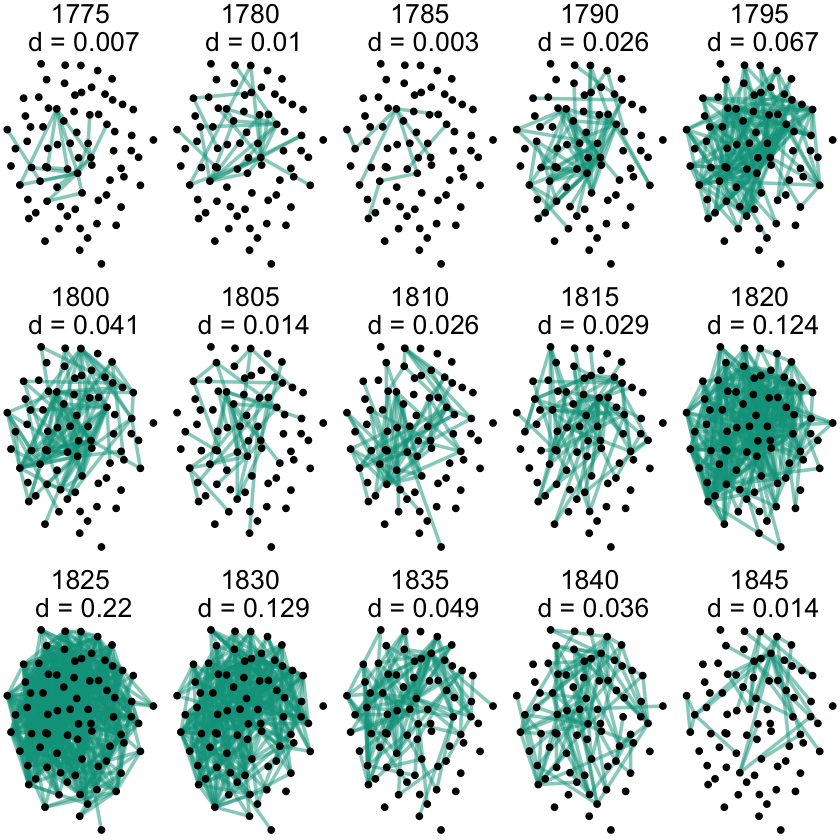

In [16]:
iamb_4 <- network(net, c("iamb_4"), wes_palette("Darjeeling1")[2])
    
iamb_4 + facet_wrap(~slice, 
                 scales="free_x", 
                 drop=T,
                 ncol = 5,
                 labeller = as_labeller(facet_labels)) + 
    theme(legend.position = "None",
         strip.text = element_text(size = 16),
         legend.text = element_text(size = 14), 
         legend.title = element_text(size = 16))

In [ ]:
ggsave(file = "../plots/Fig_3.png", plot = last_plot(), 
      dpi = 300, width = 12, height = 9, bg = "white")